# 1. Set Up

In [1]:
import math
import os
import re
import sys
import time
import json
from pathlib import Path
import subprocess
import zipfile
from pydantic import BaseModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
import gmsh

sys.path.append('/mofem_install/jupyter/thomas/mfront_example_test/src')

import setup
import core
import custom_models as cm
import utils as ut
import plotting
import calculations as calc
    
import matplotlib
matplotlib.rc('figure', figsize=(7, 7))

In [2]:
#in MPa
def initialize_parameters(custom_mesh_filepath: str = None, soil_model: cm.PropertyTypeEnum = cm.PropertyTypeEnum.le, **kwargs) -> cm.AttrDict:
    params = cm.AttrDict()
    setattr(params, "custom_mesh_filepath", custom_mesh_filepath)
    setattr(params, "soil_model", soil_model)
    for key,value in kwargs.items():
        setattr(params, key, value)
    params.interface = False
    params.pile_manager = cm.PileManager(x=0, y=0, z=0, dx=0, dy=0, R=1, r=0.975,
                                         stickup_height = 10,
                                         embedded_depth = -10.5,
                                preferred_model= cm.PropertyTypeEnum.le,
                                props = {
                                    cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=200000, poisson_ratio=0.3),
                                },
                                interface = params.interface,
                                )

    soil_layer_1 = cm.SoilLayer(
        depth = -2,
        preferred_model= params.soil_model,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=96, poisson_ratio=0.499),
            cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=96, poisson_ratio=0.499,HardeningSlope = 0.96, YieldStress = 0.3),
            cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=96, poisson_ratio=0.499, phi=np.radians(27), c=10, v=np.radians(27)),
            cm.PropertyTypeEnum.dpHYPER: cm.DruckerPragerHYPERProperties(youngs_modulus=96, poisson_ratio=0.499, phi=np.radians(27), c=10, v=np.radians(27),proximity=1e-9),
            cm.PropertyTypeEnum.mcc: cm.CamClayProperties(),
            }, 
            )
    soil_layer_2 = cm.SoilLayer(
        depth = -1.4,
        preferred_model= params.soil_model,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=182.1, poisson_ratio=0.499),
            cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=182.1, poisson_ratio=0.499,HardeningSlope = 1.821, YieldStress = 0.3),
            cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=182.1, poisson_ratio=0.499, phi=np.radians(27), c=10, v=np.radians(27)),
            cm.PropertyTypeEnum.dpHYPER: cm.DruckerPragerHYPERProperties(youngs_modulus=96, poisson_ratio=0.499, phi=np.radians(27), c=10, v=np.radians(27),proximity=1e-9),
            cm.PropertyTypeEnum.mcc: cm.CamClayProperties(),
            }, 
            )
    soil_layer_3 = cm.SoilLayer(
        depth = -7.1,
        preferred_model= params.soil_model,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=351.3, poisson_ratio=0.499),
            cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=351.3, poisson_ratio=0.499,HardeningSlope = 3.513, YieldStress = 0.3),
            cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=351.3, poisson_ratio=0.499, phi=np.radians(27), c=10, v=np.radians(27)),
            cm.PropertyTypeEnum.dpHYPER: cm.DruckerPragerHYPERProperties(youngs_modulus=96, poisson_ratio=0.499, phi=np.radians(27), c=10, v=np.radians(27),proximity=1e-9),
            cm.PropertyTypeEnum.mcc: cm.CamClayProperties(),
                 }, 
            )
    soil_layer_4 = cm.SoilLayer(
        depth = -29.5,
        preferred_model= params.soil_model,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=668.4, poisson_ratio=0.499),
            cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=668.4, poisson_ratio=0.499,HardeningSlope = 6.684, YieldStress = 0.3),
            cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=668.4, poisson_ratio=0.499, phi=np.radians(27), c=10, v=np.radians(27)),
            cm.PropertyTypeEnum.dpHYPER: cm.DruckerPragerHYPERProperties(youngs_modulus=96, poisson_ratio=0.499, phi=np.radians(27), c=10, v=np.radians(27),proximity=1e-9),
            cm.PropertyTypeEnum.mcc: cm.CamClayProperties(),
            }, 
            )
    params.interface_manager = cm.InterfaceManager(
        preferred_model = cm.PropertyTypeEnum.vM,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=96, poisson_ratio=0.3),
            cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=96, poisson_ratio=0.499,HardeningSlope = 5000, YieldStress = 20),
            cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=668.4, poisson_ratio=0.499, phi=np.radians(27), c=0, v=np.radians(27)),
            },
            )
    
    #=======================================================
    #=======================================================
    #=======================================================
    #if the soil domain is a cuboid
    params.box_manager = cm.BoxManager(x=-80, y=-80, z=0, dx=160, dy=80,
        layers=[
        soil_layer_1,
        soil_layer_2,
        soil_layer_3,
        soil_layer_4,   
        ],
        far_field_size=5,
        near_field_dist=5,
        near_field_size=0.05,
    )
    #if the soil domain is a half cylinder
    params.cylinder_manager = cm.CylinderManager(
        x=0, 
        y=0, 
        z=0, 
        dx=0, 
        dy=0, 
        r=80,
        pile_R = params.pile_manager.R,
        pile_r = params.pile_manager.r,
        layers=[
        soil_layer_1,
        soil_layer_2,
        soil_layer_3,
        soil_layer_4,   
        ],
        mesh_radial_progression = 1.3,
        mesh_radial_divisions = 10,
    )
    #=======================================================
    #=======================================================
    #=======================================================
    
    def custom_generate_physical_groups(params) -> list[cm.PhysicalGroup]:
        physical_group_list = [
            cm.PhysicalGroup(
                meshnet_id=1,
                name="MFRONT_MAT_1",
                preferred_model=params.cylinder_manager.layers[0].preferred_model,
                props=params.cylinder_manager.layers[0].props,
                ),
            cm.PhysicalGroup(
                meshnet_id=2,
                name="MFRONT_MAT_2",
                preferred_model=params.cylinder_manager.layers[1].preferred_model,
                props=params.cylinder_manager.layers[1].props,
                ),
            cm.PhysicalGroup(
                meshnet_id=3,
                name="MFRONT_MAT_3",
                preferred_model=params.cylinder_manager.layers[2].preferred_model,
                props=params.cylinder_manager.layers[2].props,
                ),
            cm.PhysicalGroup(
                meshnet_id=4,
                name="MFRONT_MAT_4",
                preferred_model=params.cylinder_manager.layers[3].preferred_model,
                props=params.cylinder_manager.layers[3].props,
                ),
            cm.PhysicalGroup(
                meshnet_id=5,
                name="MFRONT_MAT_5",
                preferred_model=params.pile_manager.preferred_model,
                props=params.pile_manager.props,
                ),
        ]
        return physical_group_list
    
    if getattr(params, "custom_mesh_filepath", False):
        try:
            params.custom_generate_physical_groups = custom_generate_physical_groups
        except NameError as e:
            raise NameError("Must provided the custom callback 'custom_generate_physical_groups' to inject attributes to the main commmand.")
   
    params.nproc = 8 # number of processors/cores used
    params.order = 2 #order of approximation functions
    params.dim = 3
    
    params.final_time = 1 # [s]
    params.time_step = 1 / 200 # [s]
    
    params.wk_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test")
    params.read_med_exe = "/mofem_install/jupyter/thomas/um_view/bin/read_med"
    params.h5m_to_vtk_converter = "/mofem_install/jupyter/thomas/um_view/bin/convert.py"
    params.partition_exe = "/mofem_install/jupyter/thomas/um_view/bin/mofem_part"
    params.exe = f"/mofem_install/jupyter/thomas/um_view/tutorials/adv-1/contact_3d"
    params.paraview_path = "/mofem_install/jupyter/thomas/ParaView-5.13.1-MPI-Linux-Python3.10-x86_64/bin/pvpython"
    params.ffmpeg_path = '/mofem_install/jupyter/thomas/ffmpeg-7.0.2-amd64-static/ffmpeg'
    params.preset_dir = '/mofem_install/jupyter/thomas/mfront_example_test/src/presets'
    
    return params

In [3]:
def postprocessing(params):
    original_pythonpath = os.environ.get("PYTHONPATH", "")
    os.environ["PYTHONPATH"] = ""

    
    @ut.track_time("PULLING A SELECTED POINT OVER TIME WITH pvpython")
    def point_to_csv(params, point: cm.Point):
        command = [
            params.paraview_path,
            "/mofem_install/jupyter/thomas/mfront_example_test/src/pvpython_scripts/point_to_time_csv.py",
            params.vtk_dir,
            point.point_against_time_csv_filepath(params),
            *point.flat(),
        ]
        # Run the command using subprocess
        process = subprocess.run(command, check=True, capture_output=True)
        
    @ut.track_time("PULLING MULTIPLE SELECTED POINTS OVER TIME WITH pvpython")
    def multiple_points_to_csv(params, points_of_interest: list[cm.Point]):
        command = [
            params.paraview_path,
            "/mofem_install/jupyter/thomas/mfront_example_test/src/pvpython_scripts/multiple_points_to_time_csv.py",
            params.vtk_dir,
            str(len(points_of_interest)),
        ]
        for point in points_of_interest:
            command.extend(point.flat())
            command.append(point.point_against_time_csv_filepath(params))
        # Run the command using subprocess
        process = subprocess.run(command, check=True)
        
    @ut.track_time("PULLING A SELECTED LINE OVER DEPTH AT THE FINAL TIMESTEP WITH pvpython")
    def line_to_csv(params, line: cm.Line):
        command = [
            params.paraview_path,
            "/mofem_install/jupyter/thomas/mfront_example_test/src/pvpython_scripts/line_to_depth_csv.py",
            params.vtk_dir,
            line.line_against_depth_csv_filepath(params),
            *line.pt1.flat(),
            *line.pt2.flat(),
        ]
        # Run the command using subprocess
        process = subprocess.run(command, check=True, capture_output=True)


    @ut.track_time("PLOTTING COLOR CONTOUR MAP WITH pvpython")
    def contours(params):
        command = [
            params.paraview_path,
            "/mofem_install/jupyter/thomas/mfront_example_test/src/pvpython_scripts/contours.py",
            params.vtk_dir,
            params.graph_dir,
            params.preset_dir,
        ]
        # Run the command using subprocess
        process = subprocess.run(command, check=True, capture_output=True)

    

    @ut.track_time("ANIMATING OVER TIME WITH pvpython")
    def animate(params, color_min, color_max):
        command = [
            params.paraview_path,
            "/mofem_install/jupyter/thomas/mfront_example_test/src/pvpython_scripts/pile_animate.py",
            params.vtk_dir,
            params.strain_animation_filepath_png,
            str(color_min),
            str(color_max),
        ]
        # Run the command using subprocess
        try:
            process = subprocess.run(command, check=True, capture_output=True)
            create_mp4_from_png_sequence(params.strain_animation_filepath_png_ffmpeg_regex, params.strain_animation_filepath_mp4, framerate=40)
            
        except subprocess.CalledProcessError as e:
            print("An error occurred:", e.stderr.decode())
        finally:
        # Restore the original PYTHONPATH
            os.environ["PYTHONPATH"] = original_pythonpath

    #Stitch together animations
    @ut.track_time("STITCHING .pngs TOGETHER with ffmpeg")
    def create_mp4_from_png_sequence(animation_filepath_png_ffmpeg_regex, animation_filepath_mp4, framerate=40):
        # Build the ffmpeg command
        ffmpeg_command = [
            params.ffmpeg_path,
            '-framerate', str(framerate),  # Set input framerate
            '-y',
            '-i', animation_filepath_png_ffmpeg_regex,  # Input image sequence (with regex pattern)
            '-c:v', 'libx264',  # Set video codec to libx264
            '-pix_fmt', 'yuv420p',  # Set pixel format for compatibility
            '-loglevel', 'warning',
            animation_filepath_mp4  # Output .mp4 file
        ]

        # Run the ffmpeg command as a subprocess
        try:
            subprocess.run(ffmpeg_command, check=True, capture_output=True)
            print(f"MP4 video created successfully: {animation_filepath_mp4}")
        except subprocess.CalledProcessError as e:
            print(f"Error occurred during ffmpeg execution: {e}")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
    try:
        # for point in points_of_interest:
            # point_to_csv(params, point)
        multiple_points_to_csv(params, params.points_of_interest)
        line_to_csv(params, params.line_of_interest)
        # contours(params)
    except subprocess.CalledProcessError as e:
        print("An error occurred:", e.stderr.decode())
    finally:
        # Restore the original PYTHONPATH
        os.environ["PYTHONPATH"] = original_pythonpath
        
    
    # df = pd.read_csv(points_of_interest[0].point_against_time_csv_filepath(params))
    # strain_magnitude = np.array(df['avg(STRAIN (Magnitude))'])
    # color_max = strain_magnitude.max()
    # color_min = strain_magnitude.min()
    # animate(params, color_min, color_max)

In [4]:
def plot_all_and_auxiliary_saves(params):
    df = pd.read_csv(params.line_of_interest.line_against_depth_csv_filepath(params))
    df = df.dropna()
    x = np.array(df['Points:0'])
    y = np.array(df['Points:1'])
    z = np.array(df['Points:2'])
    disp_x = np.array(df['DISPLACEMENT:0'])
    disp_y = np.array(df['DISPLACEMENT:1'])
    disp_z = np.array(df['DISPLACEMENT:2'])
    
    e_xx = np.array(df['STRAIN:0'])
    e_xy = np.array(df['STRAIN:1'])
    e_xz = np.array(df['STRAIN:2'])
    e_yy = np.array(df['STRAIN:4'])
    e_yz = np.array(df['STRAIN:5'])
    e_zz = np.array(df['STRAIN:8'])
    
    sig_xx = np.array(df['STRESS:0'])
    sig_xy = np.array(df['STRESS:1'])
    sig_xz = np.array(df['STRESS:2'])
    sig_yy = np.array(df['STRESS:4'])
    sig_yz = np.array(df['STRESS:5'])
    sig_zz = np.array(df['STRESS:8'])
    
    sig_1, sig_2, sig_3 = calc.calculate_principal_stresses(sig_xx, sig_yy, sig_zz, sig_xy, sig_xz, sig_yz)
    p = calc.calculate_p(sig_1, sig_2, sig_3)
    J_2 = calc.calculate_J2(sig_1, sig_2, sig_3)
    J  = np.sqrt(J_2)
    tau_oct = np.sqrt(2 * J_2)
    sig_eq = np.sqrt(3 * J_2)
    e_v, e_d = calc.calculate_volumetric_and_deviatoric_strain(e_xx, e_yy, e_zz, e_xy, e_xz, e_yz)
    graph_dir = params.line_of_interest.graph_dir(params)
    plotting.plot_x_ys(disp_x, [z], labels=["FEA"], x_label='$\mu_x$ [m]', y_label='Depth [m]', title='Depth vs $\mu_x$', save_as = f"{graph_dir}/401_z_ux.png")

    for point in params.points_of_interest:
        graph_dir = point.graph_dir(params)
        df = pd.read_csv(point.point_against_time_csv_filepath(params))
        disp_x = np.array(df['avg(DISPLACEMENT (0))'])
        disp_y = np.array(df['avg(DISPLACEMENT (1))'])
        disp_z = np.array(df['avg(DISPLACEMENT (2))'])
        
        e_xx = np.array(df['avg(STRAIN (0))'])
        e_xy = np.array(df['avg(STRAIN (1))'])
        e_xz = np.array(df['avg(STRAIN (2))'])
        e_yy = np.array(df['avg(STRAIN (4))'])
        e_yz = np.array(df['avg(STRAIN (5))'])
        e_zz = np.array(df['avg(STRAIN (8))'])
            
        sig_xx = np.array(df['avg(STRESS (0))'])
        sig_xy = np.array(df['avg(STRESS (1))'])
        sig_xz = np.array(df['avg(STRESS (2))'])
        sig_yy = np.array(df['avg(STRESS (4))'])
        sig_yz = np.array(df['avg(STRESS (5))'])
        sig_zz = np.array(df['avg(STRESS (8))'])

        sig_1, sig_2, sig_3 = calc.calculate_principal_stresses(sig_xx, sig_yy, sig_zz, sig_xy, sig_xz, sig_yz)
        p = calc.calculate_p(sig_1, sig_2, sig_3)
        J_2 = calc.calculate_J2(sig_1, sig_2, sig_3)
        J  = np.sqrt(J_2)
        tau_oct = np.sqrt(2 * J_2)
        sig_eq = np.sqrt(3 * J_2)
        e_v, e_d = calc.calculate_volumetric_and_deviatoric_strain(e_xx, e_yy, e_zz, e_xy, e_xz, e_yz)

        label = f"""{params.soil_model.value} (FEA) 
        at {point.string()}"""
        plotting.plot_x_ys(p, [sig_eq], labels=[label], x_label='Hydrostatic stress $p$', y_label='Equivalent stress $sig_{eq}$', title='Equivalent Stress vs Hydrostatic stress', save_as = f"{graph_dir}/111_sigeq_p.png")

        plotting.plot_x_ys(e_zz, [sig_eq], labels=[label], x_label='Axial Strain $\epsilon_{zz}$', y_label='Equivalent Stress $\sigma_{eq}$', title='Equivalent Stress $\sigma_{eq}$ vs Axial Strain $\epsilon_{zz}$', save_as = f"{graph_dir}/201_sigeq_eyy.png")
        plotting.plot_x_ys(e_zz, [sig_zz], labels=["test1"], x_label='Axial Strain $\epsilon_{zz}$', y_label='Stress $\sigma_{zz}$', title='Stress $\sigma_{zz}$ vs Axial Strain $\epsilon_{zz}$', save_as = f"{graph_dir}/202_sigeq_ezz.png")
        plotting.plot_x_ys(e_zz, [sig_yy], labels=["test1"], x_label='Axial Strain $\epsilon_{zz}$', y_label='Stress $\sigma_{yy}$', title='Stress $\sigma_{yy}$ vs Axial Strain $\epsilon_{zz}$', save_as = f"{graph_dir}/203_sigeq_eyy.png")
        plotting.plot_x_ys(e_zz, [sig_xx], labels=["test1"], x_label='Axial Strain $\epsilon_{zz}$', y_label='Stress $\sigma_{xx}$', title='Stress $\sigma_{xx}$ vs Axial Strain $\epsilon_{zz}$', save_as = f"{graph_dir}/204_sigeq_exx.png")

        plotting.plot_x_ys(e_zz[1:], [sig_eq[1:]/p[1:]], labels=["test1"], x_label='Axial Strain $\epsilon_{yy}$', y_label='Stress ratio $q/p$', title='Stress ratio vs Axial Strain', save_as = f"{graph_dir}/211_sigeq_div_p_eyy.png")

        plotting.plot_x_ys(e_d, [e_v], labels=["volumetric - axial"], x_label='Axial strain $\epsilon_{zz}$', y_label='Volumetric strain $\epsilon^v$', title='Volumetric strain vs Axial strain', save_as = f"{graph_dir}/302_ev_ed.png")
        plotting.plot_x_ys(e_d, [e_d], labels=["Deviatoric - axial"], x_label='Axial strain $\epsilon_{zz}$', y_label='Deviatoric strain $\epsilon^v$', title='Deviatoric strain vs Axial strain', save_as = f"{graph_dir}/303_ev_ed.png")
        plotting.plot_x_ys(e_d, [e_v], labels=["FEA"], x_label='Deviatoric strain $\epsilon^d$', y_label='Volumetric strain $\epsilon^v$', title='Volumetric strain vs Deviatoric strain', save_as = f"{graph_dir}/304_ev_ed.png")
        
        plotting.plot_x_ys(disp_x, [sig_eq], labels=["FEA"], x_label='$\mu_x$ [m]', y_label='Equivalent stress $sig_{eq}$', title='Equivalent Stress vs $\mu_x$', save_as = f"{graph_dir}/411_ux_sigeq.png")
        plotting.plot_x_ys(disp_x, [sig_xx], labels=["FEA"], x_label='$\mu_x$ [m]', y_label='Stress $\sigma_{xx}$', title='Stress $\sigma_{xx}$ vs $\mu_x$', save_as = f"{graph_dir}/412_ux_sigxx.png")
        
    data_force=pd.read_csv(params.FIX_X_1_force_log_file,sep='\s+',header=None)
    pile_tip_lateral_load = - data_force[4].values * 2 * (10 ** 6) / 1000
    
    
    df_ground_level_passive = pd.read_csv(cm.Point(x=-1,y=0,z=0).point_against_time_csv_filepath(params))
    
    ground_level_displacement = - np.array(df_ground_level_passive['avg(DISPLACEMENT (0))']) * 1000
    
    
    # Create a DataFrame from the arrays
    df_final = pd.DataFrame({
        'ground_level_displacement': ground_level_displacement,
        'pile_tip_lateral_load': pile_tip_lateral_load
    })

    # Save the DataFrame to a CSV file
    df_final.to_csv(f"{params.data_dir}/ground_level_displacement_vs_pile_tip_lateral_load.csv", index=False)
    
    plotting.plot_x_ys(ground_level_displacement, [pile_tip_lateral_load], labels=["FEA"], x_label='Ground-level displacement $\mu_x$ [mm]', y_label='Lateral load $H$ [kN]', title='Lateral load $H$ vs $\mu_x$', save_as = f"{params.graph_dir}/412_H_ux.png", show=True)

In [5]:
points_of_interest = [
        cm.Point(x=1,y=0,z=10),
        cm.Point(x=-1,y=0,z=0),
        cm.Point(x=-1,y=0,z=-10.5),
    ]
line_of_interest = cm.Line(pt1=cm.Point(x=-1,y=0,z=10), pt2=cm.Point(x=-1,y=0,z=-40),)

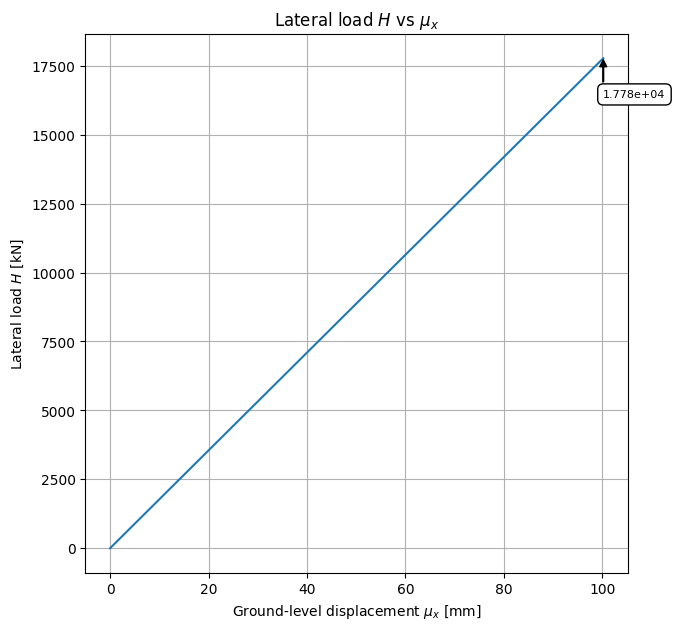

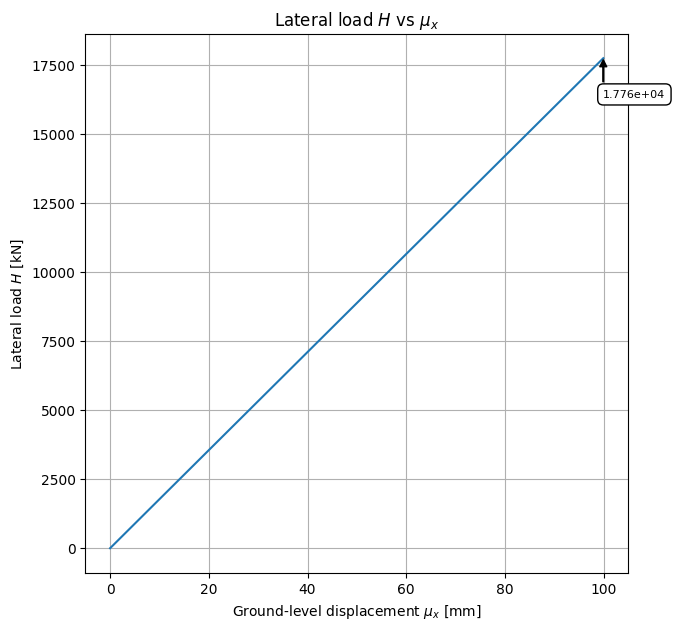

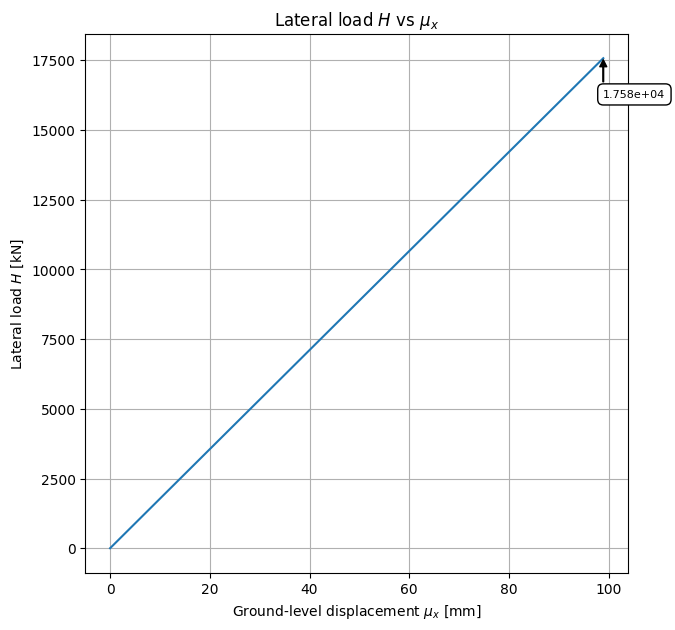

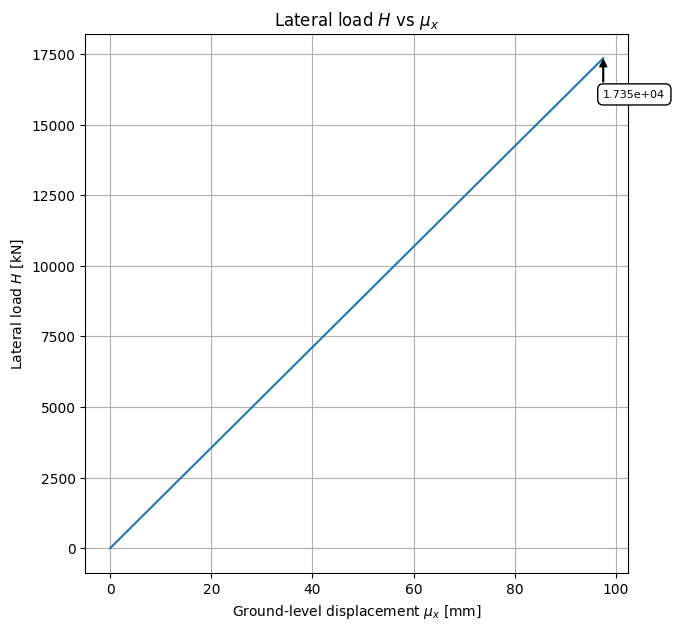

In [6]:
class InitParams(BaseModel):
    soil_model: cm.PropertyTypeEnum
    custom_mesh_filepath: str
    FEA_completed: bool
    days_since_epoch: int | None = None
    sim_otd: int | None = None


bulk_analysis_set = [
    # InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_1.cub", base="hex", FEA_completed=False, days_since_epoch=None, sim_otd=None),
    # InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_2.cub", base="hex", FEA_completed=False, days_since_epoch=None, sim_otd=None),
    # InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_3.cub", base="hex", FEA_completed=False, days_since_epoch=None, sim_otd=None),
    # InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_4.cub", base="hex", FEA_completed=False, days_since_epoch=None, sim_otd=None),
    # InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_5.cub", base="hex", FEA_completed=False, days_since_epoch=None, sim_otd=None),
    # InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_6.cub", base="hex", FEA_completed=False, days_since_epoch=None, sim_otd=None),
    # InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_7.cub", base="hex", FEA_completed=False, days_since_epoch=None, sim_otd=None),
    # InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_8.cub", base="hex", FEA_completed=False, days_since_epoch=None, sim_otd=None),
    InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_9.cub", base="hex", FEA_completed=True, days_since_epoch=96, sim_otd=6),
    InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_9.cub", base="hex", FEA_completed=True, days_since_epoch=96, sim_otd=7),
    InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_9.cub", base="hex", FEA_completed=True, days_since_epoch=96, sim_otd=8),
    InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_10.cub", base="hex", FEA_completed=True, days_since_epoch=96, sim_otd=9),
]

bulk_sim_id = "Monday"

bulk_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test/simulations/bulk_{bulk_sim_id}")
bulk_dir.mkdir(parents=True, exist_ok=True)

bulk_log = bulk_dir / "pile_bulk.log"

with open(bulk_log, 'w'): pass
parameters = {}
for i, init_params in enumerate(bulk_analysis_set):
    params = initialize_parameters(
        **init_params.dict(),
        case_name = "pile",
        
        # prescribed_force = cm.ForceBoundaryCondition(fx=0,fy=0,fz=0),
        prescribed_disp = cm.SurfaceBoundaryCondition(disp_ux=1, disp_uy=0 ,disp_uz=0),
        
        points_of_interest = [
            cm.Point(x=1,y=0,z=10),
            cm.Point(x=-1,y=0,z=0),
            cm.Point(x=-1,y=0,z=-10.5),
        ],
        line_of_interest = cm.Line(pt1=cm.Point(x=-1,y=0,z=10), pt2=cm.Point(x=-1,y=0,z=-40),),
    )
    # 2. Simulation Parameters
    params = setup.setup(params) # 3. Log paths and meta
    if params.FEA_completed:
        # postprocessing(params) # 7. Extract data from .vtk files 
        pass
    else:
        core.generate_mesh(params) # 4. Generate the mesh
        core.mofem_compute(params) # 5. Running the analysis and export to .vtk file format
        core.export_to_vtk(params)
        # core.quick_visualization(params) # 6. Visualize final time step .vtk file
        postprocessing(params) # 7. Extract data from .vtk files 
        
    plot_all_and_auxiliary_saves(params) # 8. Plotting

    props = cm.BulkAnalysisProps(
        data_dir = params.data_dir,
        mesh_name_appended = params.mesh_name_appended,
        total_force_log_file = params.total_force_log_file,
        FIX_X_1_force_log_file = params.FIX_X_1_force_log_file,
        DOFs_log_file =  params.DOFs_log_file,
        ux_log_file= params.ux_log_file,
        full_fe_log = params.log_file,

    )
    parameters[f"{i}"] = props.model_dump_json(indent=2)
    

        
with open(bulk_log, 'w') as f:
    json.dump(parameters, f, indent=2)

'/mofem_install/jupyter/thomas/mfront_example_test/simulations/bulk_Monday/graphs/006_WallTime_DOFs.png'

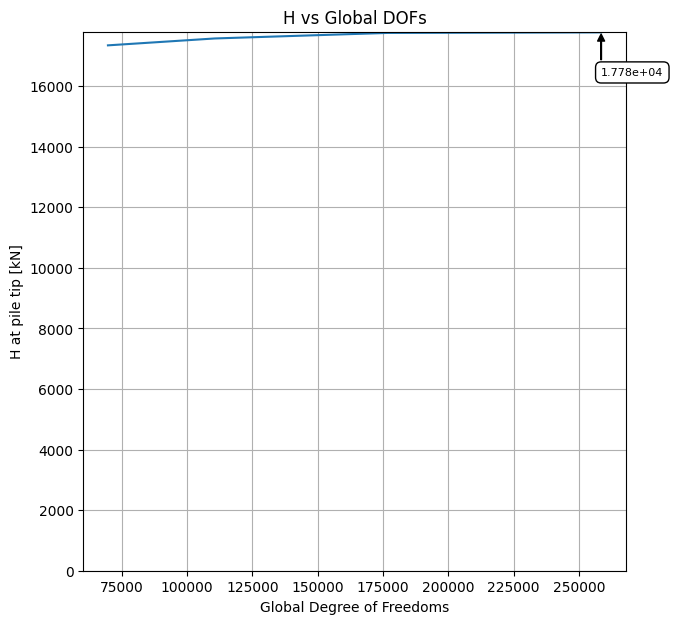

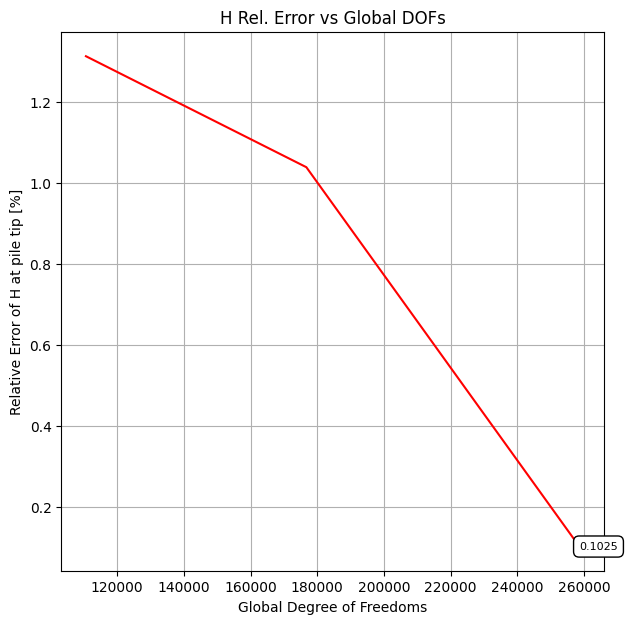

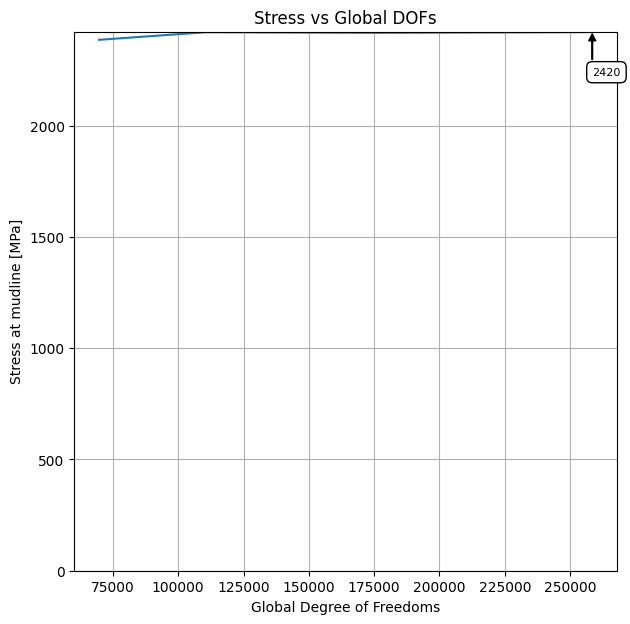

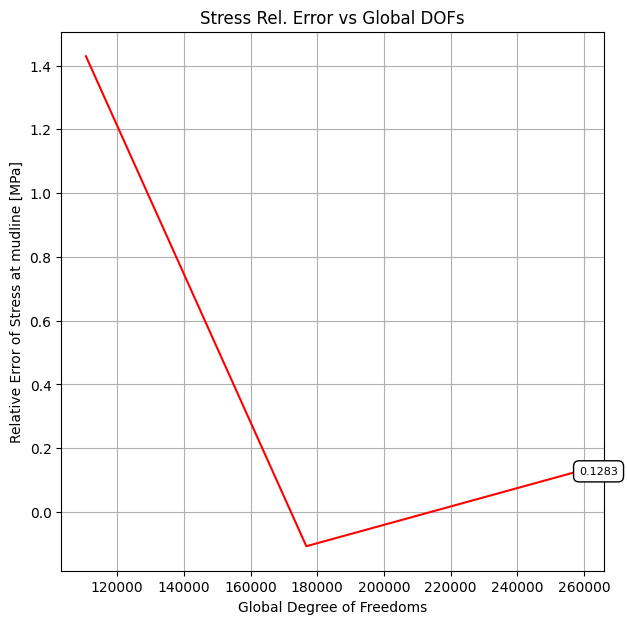

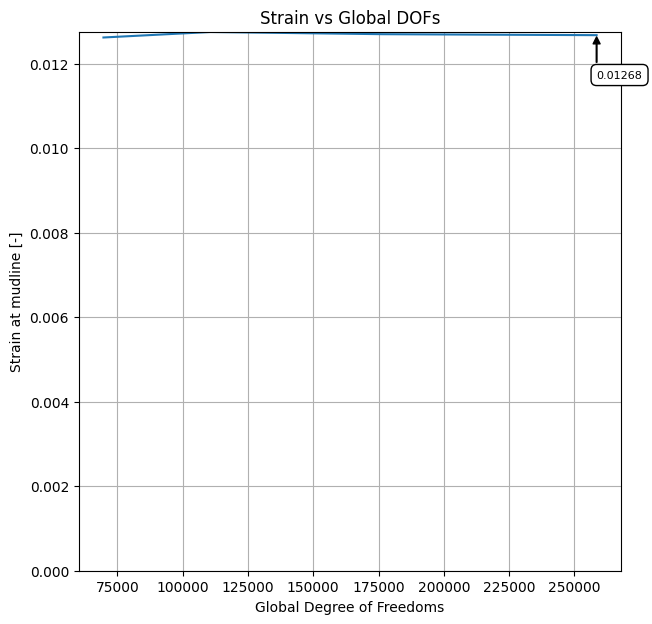

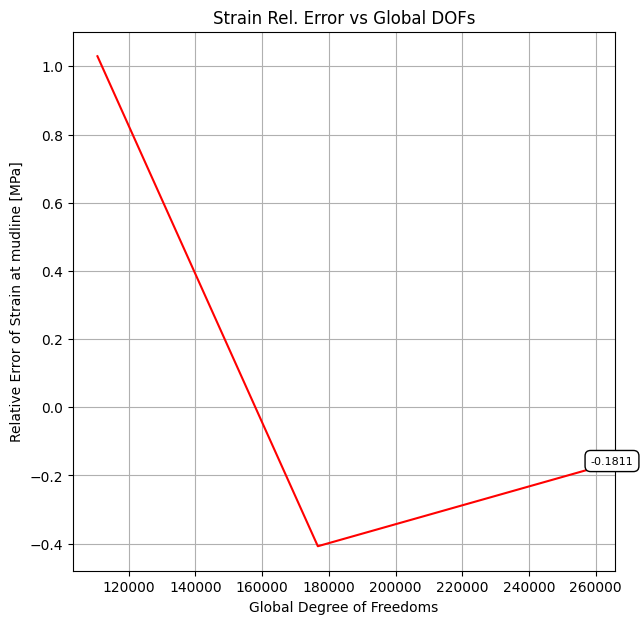

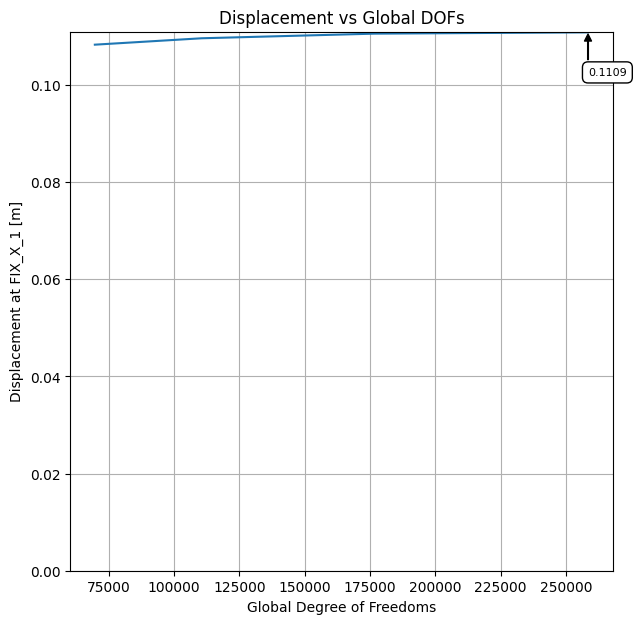

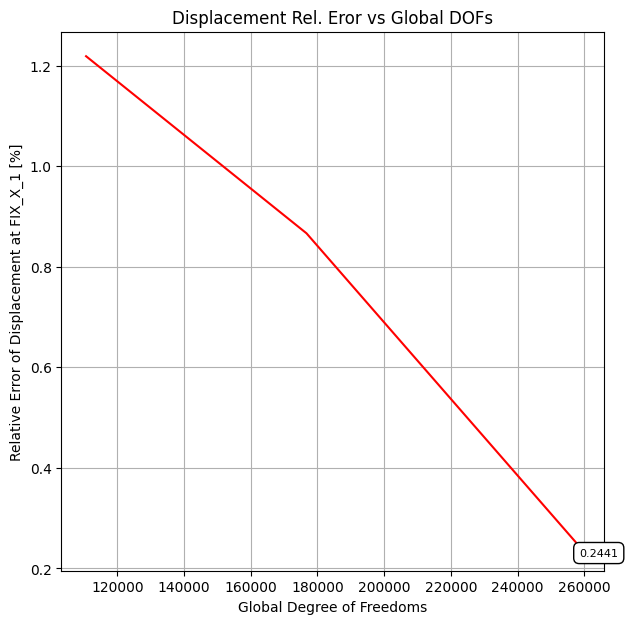

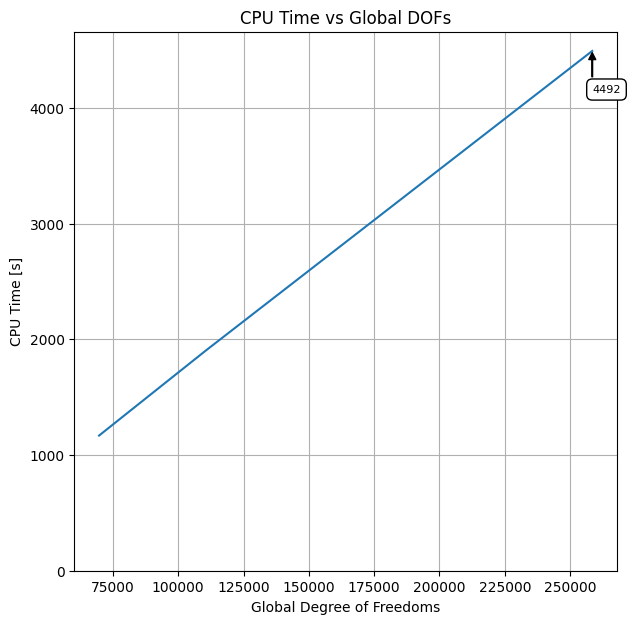

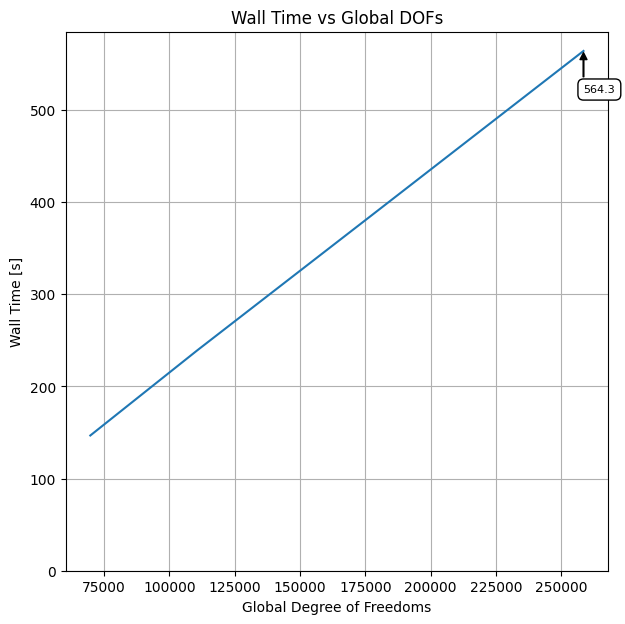

In [11]:
from pathlib import Path
import os
import json
import sys

import pydantic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('/mofem_install/jupyter/thomas/mfront_example_test/src')

import custom_models as cm
import plotting

bulk_sim_id = "Monday"
bulk_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test/simulations/bulk_{bulk_sim_id}")
bulk_log = bulk_dir / "pile_bulk.log"

if os.path.exists(bulk_log):
    with open(bulk_log, 'r') as f:
        logs = json.load(f)
else:
    raise FileNotFoundError(f"The bulk log with the id '{bulk_sim_id}'is not found. Possibly because this bulk analysis was not performed yet?")

bulk_graph_dir = bulk_dir / "graphs"
bulk_graph_dir.mkdir(parents=True, exist_ok=True)
bulk_csv = bulk_dir / "pile_bulk.csv"

DOFs = [] # number of DOFs
FIX_1_strain_energies = [] # values of energy

df = {
    "DOFs": [],
    "H": [],
    "final_stress": [],
    "final_strain": [],
    "final_disp": [],
    "final_disp_relative_error": [],
    "final_stress_relative_error": [],
    "final_strain_relative_error": [],
    "H_relative_error": [],
    "compute_cpu_time": [],
    "compute_wall_time": [],
    "compute_cpu_time_relative_error": [],
    "compute_wall_time_relative_error": [],
}

previous_values = {
    "final_disp": None,
    "final_stress": None,
    "final_strain": None,
    "H": None,
    "compute_cpu_time": None,
    "compute_wall_time": None,
}

for i, log in reversed(list(logs.items())):
    params = cm.BulkAnalysisProps.parse_raw(log)
    data_poi_mudline=pd.read_csv(points_of_interest[1].point_against_time_csv_filepath(params))
    data_tot_force=pd.read_csv(params.total_force_log_file,sep='\s+',header=None)
    data_force=pd.read_csv(params.FIX_X_1_force_log_file,sep='\s+',header=None)
    data_dofs=pd.read_csv(params.DOFs_log_file,sep='\s+',header=None)
    data_ux=pd.read_csv(params.ux_log_file,sep='\s+',header=None)
    
    cpu_time_result = subprocess.run(
        f"grep 'Total CPU time:' {params.full_fe_log} | awk '{{print $4}}'",
        shell=True, text=True, capture_output=True
    )
    total_cpu_time = float(cpu_time_result.stdout.strip())
    
    # Extract Wall-clock time
    wall_time_result = subprocess.run(
        f"grep 'Wall-clock time:' {params.full_fe_log} | awk '{{print $3}}'",
        shell=True, text=True, capture_output=True
    )
    wall_clock_time = float(wall_time_result.stdout.strip())
    
    
    
    pile_tip_lateral_load = - data_force[4].values * 2 * (10 ** 6) / 1000
    ground_level_passive_lateral_final_stress = data_poi_mudline["avg(STRESS (Magnitude))"].iloc[-1]
    ground_level_passive_lateral_final_strain = data_poi_mudline["avg(STRAIN (Magnitude))"].iloc[-1]
    ground_level_passive_lateral_final_disp = data_poi_mudline["avg(DISPLACEMENT (Magnitude))"].iloc[-1]
    DOF = data_dofs[15][0]
    
    # ux_values = data_ux[5]  # Assuming the 5th column (index 4) contains ux values
    # ux_increments = np.diff(ux_values)  # Compute differences between consecutive ux values (199 increments)
    # Compute corresponding force values (ignoring the first force for integration purposes)
    # force_values = data_force[4][1:].values  # Assuming the 5th column (index 4) contains force values from index 1 onward
    # Perform numerical integration: sum(force * increment) * 0.5
    
    current_values = {
        "final_disp": ground_level_passive_lateral_final_disp,
        "final_stress": ground_level_passive_lateral_final_stress,
        "final_strain": ground_level_passive_lateral_final_strain,
        "H": pile_tip_lateral_load[-1],
        "compute_cpu_time": total_cpu_time,
        "compute_wall_time": wall_clock_time,
    }
    
    for key in current_values:
        if previous_values[key] is not None:
            relative_error = (current_values[key] - previous_values[key]) / abs(previous_values[key]) * 100
            df[f"{key}_relative_error"].append(relative_error)
        else:
            df[f"{key}_relative_error"].append(None)  # No previous value to compare with
        previous_values[key] = current_values[key]
    
    
    df["DOFs"].append(DOF)
    df["H"].append(pile_tip_lateral_load[-1])
    df["final_stress"].append(ground_level_passive_lateral_final_stress)
    df["final_strain"].append(ground_level_passive_lateral_final_strain)
    df["final_disp"].append(ground_level_passive_lateral_final_disp)
    df["compute_cpu_time"].append(total_cpu_time)
    df["compute_wall_time"].append(wall_clock_time)

df = pd.DataFrame(df)

df.to_csv(bulk_csv)

plotting.plot_x_ys(df["DOFs"], [df["H"]], labels=[""], x_label='Global Degree of Freedoms', y_label='H at pile tip [kN]', title='H vs Global DOFs', save_as = f"{bulk_graph_dir}/001_H_DOFs.png", show=True, enforce_pass_through_zero=True)
plotting.plot_x_ys(df["DOFs"], [df["H_relative_error"]], labels=[""], colors=["r"], x_label='Global Degree of Freedoms', y_label='Relative Error of H at pile tip [%]', title='H Rel. Error vs Global DOFs', save_as = f"{bulk_graph_dir}/001_1_H_DOFs_rel_error.png", show=True, enforce_pass_through_zero=False)

plotting.plot_x_ys(df["DOFs"], [df["final_stress"]], labels=[""], x_label='Global Degree of Freedoms', y_label='Stress at mudline [MPa]', title='Stress vs Global DOFs', save_as = f"{bulk_graph_dir}/002_Stress_DOFs.png", show=True, enforce_pass_through_zero=True)
plotting.plot_x_ys(df["DOFs"], [df["final_stress_relative_error"]], labels=[""], colors=["r"], x_label='Global Degree of Freedoms', y_label='Relative Error of Stress at mudline [MPa]', title='Stress Rel. Error vs Global DOFs', save_as = f"{bulk_graph_dir}/002_1_Stress_DOFs_rel_error.png", show=True, enforce_pass_through_zero=False)


plotting.plot_x_ys(df["DOFs"], [df["final_strain"]], labels=[""], x_label='Global Degree of Freedoms', y_label='Strain at mudline [-]', title='Strain vs Global DOFs', save_as = f"{bulk_graph_dir}/003_Strain_DOFs.png", show=True, enforce_pass_through_zero=True)
plotting.plot_x_ys(df["DOFs"], [df["final_strain_relative_error"]], labels=[""], colors=["r"], x_label='Global Degree of Freedoms', y_label='Relative Error of Strain at mudline [MPa]', title='Strain Rel. Error vs Global DOFs', save_as = f"{bulk_graph_dir}/003_1_Strain_DOFs_rel_error.png", show=True, enforce_pass_through_zero=False)


plotting.plot_x_ys(df["DOFs"], [df["final_disp"]], labels=["Displacement at Pile Tip [m]"], colors=None,x_label='Global Degree of Freedoms', y_label='Displacement at FIX_X_1 [m]', title='Displacement vs Global DOFs', save_as = f"{bulk_graph_dir}/004_Displacement_DOFs.png", show=True, enforce_pass_through_zero=True)
plotting.plot_x_ys(df["DOFs"], [df["final_disp_relative_error"]], labels=["Relative error [%]"], colors=["r"],x_label='Global Degree of Freedoms', y_label='Relative Error of Displacement at FIX_X_1 [%]', title='Displacement Rel. Eror vs Global DOFs', save_as = f"{bulk_graph_dir}/004_1_Displacement_DOFs_rel_error.png", show=True, enforce_pass_through_zero=False,annotate_last_datapoint=True)

plotting.plot_x_ys(df["DOFs"], [df["compute_cpu_time"]], labels=[""], x_label='Global Degree of Freedoms', y_label='CPU Time [s]', title='CPU Time vs Global DOFs', save_as = f"{bulk_graph_dir}/005_CPUTime_DOFs.png", show=True, enforce_pass_through_zero=True)
plotting.plot_x_ys(df["DOFs"], [df["compute_wall_time"]], labels=[""], x_label='Global Degree of Freedoms', y_label='Wall Time [s]', title='Wall Time vs Global DOFs', save_as = f"{bulk_graph_dir}/006_WallTime_DOFs.png", show=True, enforce_pass_through_zero=True)